<div style="background: linear-gradient(135deg, #034694 0%, #1E8449 50%, #D4AC0D 100%); color: white; padding: 20px; border-radius: 10px; box-shadow: 0 4px 8px rgba(0,0,0,0.2);">
    <h1 style="color: #FFF; text-shadow: 1px 1px 3px rgba(0,0,0,0.5);">💬 | Step 3: Be More Cost-Effective With Distillation </h1>
        <p style="font-size: 16px; line-height: 1.6;">
            We have the model customized to provide the right tone and style. But we are using a large (slow and expensive) model for a very narrow and focused task. Let's see how we can distill the knowledge to a smaller (faster and cheaper) model to get comparable accuracy with better efficiency - by trading in general-purpose LLMs for a narrower task-specific intelligence.
        </p>
</div>

<div style="display: flex; align-items: center; justify-content: left; padding: 5px; height: 40px; background: linear-gradient(90deg, #333333 0%, #777777 50%, #BBBBBB 100%); border-radius: 8px; box-shadow: 0 2px 8px rgba(0,0,0,0.12); font-size: 1.5em; font-weight: bold; color: #fff;">
    Step 1 : Understand Zava Scenarios
</div>
<br/>
<div style="display: flex; align-items: center; justify-content: left; padding: 5px; height: 40px; background: linear-gradient(90deg, #333333 0%, #777777 50%, #BBBBBB 100%); border-radius: 8px; box-shadow: 0 2px 8px rgba(0,0,0,0.12); font-size: 1.5em; font-weight: bold; color: #fff;">
    Step 2 : Be More Helpful With SFT
</div>
<br/>
<div style="display: flex; align-items: center; justify-content: left; padding: 5px; height: 40px; background: linear-gradient(90deg, #7873f5 0%, #ff6ec4 100%); border-radius: 8px; box-shadow: 0 2px 8px rgba(0,0,0,0.12); font-size: 1.5em; font-weight: bold; color: #fff;">
    Step 4: Be More Precise with RAFT
</div>

---

## 1. Check Environment Setup



In [1]:
# First, make sure required environment variables are set
import os

openai_key = os.getenv("AZURE_OPENAI_API_KEY")
openai_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
model_name = "gpt-4.1"
api_version = os.getenv("AZURE_OPENAI_API_VERSION", "2025-02-01-preview")

if not openai_key or not openai_endpoint:
    print("Error: Missing AZURE_OPENAI_KEY or AZURE_OPENAI_ENDPOINT environment variable.")

print("Using Model:", model_name)
print("Using API Version:", api_version)

Using Model: gpt-4.1
Using API Version: 2025-02-01-preview


In [2]:
# Then create an Azure OpenAI Client instance
from openai import AzureOpenAI

client = AzureOpenAI(
    azure_endpoint=os.environ.get("AZURE_OPENAI_ENDPOINT"),
    api_key=os.environ.get("AZURE_OPENAI_API_KEY"),
    api_version="2025-04-01-preview",
)

In [3]:
# And create a handy UUID we can use to track each run of this notebook
import uuid
UNIQUE_ENOUGH_KEY = str(uuid.uuid4()).split("-")[0]

---
## 2. Building Our Grader

Distillation is about having a "teacher" model transfer its learning to a "student" model, thereby allowing it to perform a _narrower_ task with comparable accuracy. To understand if our distillation had the desired effect, we typically _grade_ the student model before and after distillation - and show that the grades on that task improved significantly.

To do this, we need a _grader_ - some model that is capable of "reasoning" on a given response to see if it meets our desired criteria for "tone & style". By using the same grader throughout, we can make sure we get a consistent outcome in terms of evaluations. To create an effective grader we take 3 steps:

1. We curate a set of **baseline** questions and answers that are the gold standard for responses. A "good" grader would rank these very highly when asked.
2. We define a set of **grading** criteria that the grader will use to come up with a score on the responses. These must be clear and consistent guidelines.
3. We run the grader on that gold standard to see how our **assessment** rubric holds up. If the results look good, we have a grader ready to go - else we refine and retry.

By the end of this step, we will have an effective grader ready to use!




### 2.1 Curate Baseline Responses

In our case, we can simply take a subset of the training data from the previous step since we know it is the kind of "good" responses we want to see. We store it in a new file (`distill_sft_baseline.json`) that we can then upload to our Azure AI Foundry project, for use in a later step. Let's review the data in the file and upload it.

In [4]:
import pandas as pd

# Read the JSONL file into a DataFrame and print the first 5 rows in 2 columns
baseline_jsonl_df = pd.read_json("../data/distill_sft_baseline.jsonl", lines=True)
# Display all columns and set display width to show full text in the output
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 200)
pd.DataFrame(
    [
        {"question": row["item"]["question"], "answer": row["item"]["answer"]}
        for _, row in baseline_jsonl_df.head(5).iterrows()
    ]
)

,question,answer
0,Is water-based polyurethane better than oil-based?,"🤔 Both have benefits! Water-based at $43 dries faster, oil-based at $34 gives amber tone. Which matters most?"
1,Can I get detail brushes for trim work?,"🎨 Certainly, you can! Artist Detail Brush Set at $13 provides precise control for trim. Angled options too?"
2,What's the cheapest interior paint option?,💰 Best budget choice! Premium Interior Latex Flat at $40 is our most affordable interior option. How many rooms?
3,What's the best brush for latex paint?,🖌️ Perfect match! Synthetic Brush Set at $16 works best with latex - no bristle damage. What surface type?
4,What paint should I use for my kitchen cabinets?,🍳 Great question! Interior Semi-Gloss Paint at $47 resists grease and moisture perfectly. Need primer too?


### 2.2 Upload Baseline Data To Cloud

In [5]:
# Create a cloud-hosted file with baseline data for evaluations (purpose="evals")
# An "evals" file is a special type of file that can be used in evaluation jobs 
# - it has to be in JSONL format but its properties depend on how grader is setup
grader_eval_file = None
with open("../data/distill_sft_baseline.jsonl", "rb") as f:
    grader_eval_file = client.files.create(purpose="evals", file=f)
    grader_eval_file = client.files.wait_for_processing(grader_eval_file.id)

print(f"Created eval file:\n{grader_eval_file.to_json(indent=2)}")

Created eval file:
{
  "id": "file-159f4481cff940d08b8537b857813188",
  "bytes": 3867,
  "created_at": 1759394235,
  "filename": "distill_sft_baseline.jsonl",
  "object": "file",
  "purpose": "evals",
  "status": "processed"
}


### 2.3 Create a Helpfulness Evaluator

The Grader is just like a custom evaluator that takes an input ("question", "answer") and scores it for the desired metric ("Helpfulness") using a set of custom criteria that we define. This is an example of AI-Assisted evaluation (or LLM as a judge) where we use an LLM to execute a task ("grader this") where we describe the parameters of the task in the prompt template we provide. Let's see that in action.

In [6]:
# We'll use the most capable reasoning model as our grader.
GRADER_MODEL = "o3"

In [7]:
# Next we create a custom Grader that will score the responses for "Helpfulness" on a scale of 0-10
# using the custom rubric below - where 0 is "not helpful at all" and 10 is "extremely helpful".

# We want it to grader our "student" responses later, based on the same criteria. So let's make sure we get our rubric right.
# We want good answers to score high - and bad answers to be penalized heavily (get 0)

GRADER_PROMPT = """

You are an expert in assessing polite and helpful customer service responses

You'll be given a conversation in the form of a question and answer. 

## Scoring Criteria

Judge the answer by using two metrics to compute a final score.

### Metric 1: Is the answer polite?

Give this a score in the range of 1 to 5 where:
- 1 means the answer was rude, disrespectful or dismissive
- 3 means the answer was neutral, neither polite nor rude
- 5 means the answer had an emoji, a warm, respectful tone; acknowledges the user or context; optional greeting; no blame or dismissiveness.

### Metric 2: Is the answer helpful?

Give this a score in the range of 1 to 5 where:
- 1 means the response did not end with an offer to help further
- 3 means the response ended with a generic offer to help
- 5 means the response directly answers the question, provides concrete next steps/resources, ends with a specific offer to help related to the user’s need.

### Metric 3: Is the answer informative?
Give this a score of 0 or 1 where:
- 0 means the answer did not mention any specific product or product-related fact
- 1 means the answer mentions a specific product/feature/policy/setting or concrete fact/step clearly relevant.

### Final Score
The final score you must decide should be based on a weighted blend of Metric 1 and
Metric 2 using the formula: `(Metric 1 + Metric 2) * (Metric 3)`

This means that if Metric 3 is zero, the final score must be zero.

## Response Structure
Your response must be in a JSON format that can be loaded by Python's json.loads()
function. It must resemble the following:

```
{
  "steps": [
    { 
      "description": <one sentence describing your reasoning for Metric 1>", 
      "result": <string representation of Metric 1's score> 
    },
    { 
      "description": <one sentence describing your reasoning for Metric 2>", 
      "result": <string representation of Metric 2's score> 
    }
  ],
  "result": <floating point value of the Final Score>
}

## General Guidance
The questions will be about paint products and related topics. Deep research is not required. Use common sense to determine if the answer is polite, helpful and factual.

```
"""

### 2.4 Put the Grader Together

In [8]:
# Now we define our Evaluation for validating our choice in grader prompt and model.

# The entire user prompt is data driven from the file. No generation is done using
# a model in this case, just simple string substitution using this pattern. This
# means we directly reference the two fields in our baseline.jsonl file.

USER_PROMPT = """
Q: {{item.question}}
A: {{item.answer}}
"""

INPUT = [
    {
        "type": "message",
        "role": "system",
        "content": { "type": "input_text", "text": GRADER_PROMPT }
    },
    {
        "type": "message",
        "role": "user",
        "content": { "type": "input_text", "text": USER_PROMPT }
    }
]

# We need to describe what our evaluation dataset looks like.
SCHEMA = {
    "type": "object",
    "properties": {
        "question": { "type": "string" },
        "answer": { "type": "string" },
    }
}
DATA_SOURCE = {
    "item_schema": SCHEMA,
    "include_sample_schema": False,
    "type": "custom",
}

# Lastly, we define test criteria that combines all the above.
TESTING_CRITERIA = {
    "name": "Zava Tone Grader",
    "type": "score_model",
    "model": GRADER_MODEL,
    "input": INPUT,
    "range": [1.0, 10.0],    # Our grader scores in a range from 1 to 10
    "pass_threshold": 4.0,   # Let's say a 4 is "passing" for now.
}

### 2.5 Submit The Evaluation Task

In [9]:
# We've set up the parameters for our Eval, now we create it via the API.
grader_eval = client.evals.create(
    name=f"zava-tone-baseline-{UNIQUE_ENOUGH_KEY}",
    data_source_config=DATA_SOURCE,
    testing_criteria=[TESTING_CRITERIA],
)

print(f"⚖️ Submitted grader evaluation {grader_eval.id}.")

⚖️ Submitted grader evaluation eval_68de39bb9f588191a110fdb7130be2a9.


### 2.6 Run The Evaluation Job

In [10]:
# Our evaluation needs a test run. This is where we let it know to use our
# "gold standard" file (baseline.jsonl) to test our grader.

RUN_DATA_SOURCE = {
    "type": "jsonl",
    "source": { "type": "file_id", "id": grader_eval_file.id }
}
grader_run = client.evals.runs.create(
    name=f"zava-tone-grader-{GRADER_MODEL}",
    eval_id=grader_eval.id,
    data_source=RUN_DATA_SOURCE,
)
print(f"🏃‍➡️ Submitted run {grader_run.id} for {grader_eval.id}.")

🏃‍➡️ Submitted run evalrun_68de39bce56881918f3e58c7ab86825c for eval_68de39bb9f588191a110fdb7130be2a9.


### 2.7 Poll For Evaluation Results

In [11]:
# An Eval Run takes time to complete. Let's actively wait for it to finish before continuing.
from IPython.display import clear_output
import time

start_time = time.time()

grader_run = client.evals.runs.retrieve(eval_id=grader_eval.id, run_id=grader_run.id)
while grader_run.status not in ["completed", "failed"]:
    time.sleep(5)
    clear_output(wait=True)

    grader_run = client.evals.runs.retrieve(eval_id=grader_eval.id, run_id=grader_run.id)
    now = time.time()
    mins, secs = int((now - start_time) // 60), int((now - start_time) % 60)
    print(f"⏱️ Elapsed time: {mins} minutes {secs} seconds")

print(f"🏁 Run {grader_run.id}: {grader_run.status}!")

⏱️ Elapsed time: 1 minutes 24 seconds
🏁 Run evalrun_68de39bce56881918f3e58c7ab86825c: completed!


### 2.8 View & Analyze Results

You can see these on the Azure AI Foundry portal - or run a script to visualize them here

Get Evaluation Runs: eval_68de39bb9f588191a110fdb7130be2a9

Combined Evaluation Summary
                                  Run ID            Run Name Model    Status Pass Percentage (%) Error Percentage (%)                         Evaluation ID             Evaluation Name
evalrun_68de39bce56881918f3e58c7ab86825c zava-tone-grader-o3  None completed               100.0                  0.0 eval_68de39bb9f588191a110fdb7130be2a9 zava-tone-baseline-a5b8b579


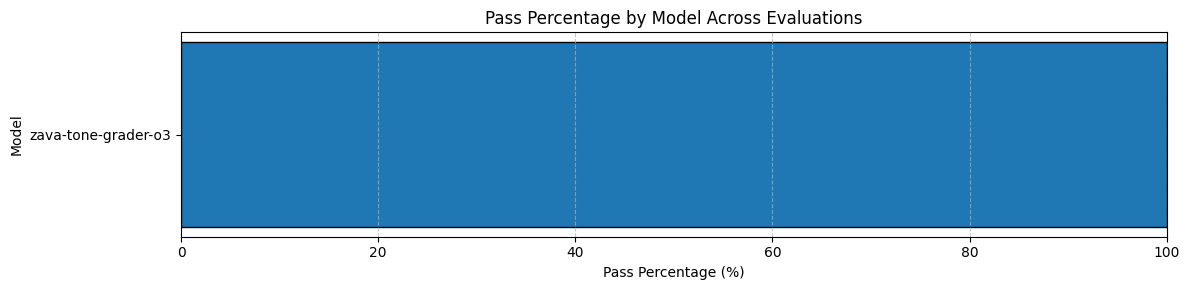

Fetching scores...
Failed to fetch output items for run evalrun_68de39bce56881918f3e58c7ab86825c. Error: 'Result' object has no attribute 'get'


In [12]:
# We've got a handy script for rendering the results from an Evaluations Runs. Let's
# eyeball this stuff. It uses the Evals API to retrieve the scores and plot them.
from eval_utils import display_evaluation_summary

display_evaluation_summary(client, [grader_eval.id], x_range=(0, 10))

# We should see that our grader generally thinks our "gold standard" is pretty on-brand for Zava tone. 
# This is where we'd iterate on tuning the grader, making sure we
# clearly capture features for it to score, etc. We're keeping it simple for now.

---

## 3. Baseline Testing Our Candidate Models

### 3.1 Curate Q&A Dataset

In [13]:
import pandas as pd

# Read the JSONL file into a DataFrame and print the first 5 rows in 2 columns
qa_jsonl_df = pd.read_json("../data/distill_sft_qa.jsonl", lines=True)
# Display all columns and set display width to show full text in the output
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 200)
pd.DataFrame(
    [
        {"question": row["item"]["question"], "answer": row["item"]["answer"]}
        for _, row in qa_jsonl_df.head(5).iterrows()
    ]
)


,question,answer
0,What's the best paint for kitchen walls?,Interior Semi-Gloss Paint is ideal for kitchens due to its moisture resistance and washable finish.
1,How much does Premium Interior Latex Flat cost?,$40.
2,What type of paint should I use for bathroom walls?,"Interior Semi-Gloss Paint, as it's moisture resistant and washable."
3,Is there an environmentally friendly paint option available?,"Yes, Zero VOC Interior Paint for healthy indoor air quality."
4,What's the price of Zero VOC Interior Paint?,$52.


### 3.2 Split Training & Validation

In [14]:
import json

qa = []
with open("../data/distill_sft_qa.jsonl", "r") as f:
    for line in f.readlines():
        qa.append(json.loads(line))

print(f"Number of Q/A pairs: {len(qa)}")


Number of Q/A pairs: 306


In [15]:

# First we'll randomize it to maybe prove a point that this isn't totally staged 😜
from random import shuffle
shuffle(qa)

# Now we split 50/50.
split_at = int(len(qa) / 2)
qa_baseline = qa[:split_at]
qa_validation = qa[split_at:]

# Check it.
print(f"{len(qa_baseline)} pairs for baseline testing, {len(qa_validation)} for validation.")

153 pairs for baseline testing, 153 for validation.


### 3.3 Upload baseline (training) set

In [16]:
# Now we'll upload our baseline dataset and prepare our Evaluation. We need to save the data
# to disk first for...reasons...because of the OpenAI SDK. That's fine.
filename = f"./zava-tone-baseline-{UNIQUE_ENOUGH_KEY}.jsonl"

with open(filename, "w") as f:
    for row in qa_baseline:
        json.dump(row, f)
        f.write("\n")

baseline_file = None
with open(filename, "rb") as f:
    baseline_file = client.files.create(purpose="evals", file=f)
    baseline_file = client.files.wait_for_processing(baseline_file.id)

print(f"Created baseline file:\n{baseline_file.to_json(indent=2)}")

Created baseline file:
{
  "id": "file-0c944033a0de47fd83452187ed1209d5",
  "bytes": 26865,
  "created_at": 1759394327,
  "filename": "zava-tone-baseline-a5b8b579.jsonl",
  "object": "file",
  "purpose": "evals",
  "status": "processed"
}


### 3.4 Create The Baseline Evaluation

In [17]:
# We'll now build out the Evaluation details. In this case, we'll *generate* responses
# using a base model, unlike before where we used the pre-canned results just to test
# the grader.

# We'll use a simple system prompt to show how distillation and fine-tuning let us
# get away without overly complex prompt engineering.
SYSTEM_PROMPT = "You are Cora, a polite, factual and helpful assistant for Zava, a DIY hardware store."

# We'll use a flee of base models as our baseline, including `o3` (our grader).
BASE_MODELS = [
    "o3-mini",
    "o4-mini",
    "gpt-4.1",
    "gpt-4.1-nano",
    "gpt-4o-mini"
]

# The prompt we'll grade will look like this pattern. Similar to before, but now we're
# going to use {{sample.output_text}} to substitute what the model under test generates.
USER_PROMPT = """
Q: {{item.question}}
A: {{sample.output_text}}
"""

# Input to our grader remains the same as before, but we reproduce it here for context.
INPUT = [
    {
        "type": "message",
        "role": "system",
        "content": { "type": "input_text", "text": GRADER_PROMPT }
    },
    {
        "type": "message",
        "role": "user",
        "content": { "type": "input_text", "text": USER_PROMPT }
    }
]

# The schema and data source are similar, but with one major difference noted below.
SCHEMA = {
    "type": "object",
    "properties": {
        "question": { "type": "string" },
        "answer": { "type": "string" },
    },
}
DATA_SOURCE = {
    "item_schema": SCHEMA, 
    "include_sample_schema": True, # Note this change! Needed for data gen.
    "type": "custom"
}

# Same testing criteria, reproduced again for context.
TESTING_CRITERIA = {
    "name": "Zava Tone Grader",
    "type": "score_model",
    "model": GRADER_MODEL,
    "input": INPUT,
    "range": [1.0, 10.0],
    "pass_threshold": 4.0,
}

# We create one Evaluation for *all* our base models. Each model is tested in a
# distinct Run that we'll define next.
baseline_eval = client.evals.create(
    name=f"zava-tone-baseline-{UNIQUE_ENOUGH_KEY}",
    data_source_config=DATA_SOURCE,
    testing_criteria=[TESTING_CRITERIA]
)
print(f"⚖️ Created baseline eval {baseline_eval.id}")

⚖️ Created baseline eval eval_68de3a17b1848191a4c68a70ea12d5be


### 3.5 Run Baseline Evaluation

In [18]:
# Each run gets its own data source definition as it needs to specify a different
# model deployment to use for generation. The template is the prompt template
# sent to the model under test. It uses the simple Clippy system prompt and for
# the user input, we use the "question" from the baseline Q&A data file.
baseline_runs = []
for model in BASE_MODELS:
    RUN_DATA_SOURCE = {
        "type": "completions",
        "model": model,
        "source": { "type": "file_id", "id": baseline_file.id },
        "input_messages": {
            "type": "template",
            "template": [
                { 
                    "type": "message", 
                    "role": "system", 
                    "content": { "type": "input_text", "text": SYSTEM_PROMPT },
                },
                { 
                    "type": "message", 
                    "role": "user", 
                    "content": { "type": "input_text", "text": "{{item.question}}" },
                },
            ],
        },
        "sampling_params": { "max_completions_tokens": 20_000 } if model.startswith("o") else { "max_completions_tokens": 100 }, # XXX
    }
    run = client.evals.runs.create(
        name=f"{model}-{UNIQUE_ENOUGH_KEY}", 
        eval_id=baseline_eval.id,
        data_source=RUN_DATA_SOURCE, 
    )
    print(f"🏃‍➡️ Created run {run.id} for eval {baseline_eval.id}")
    baseline_runs.append(run)

🏃‍➡️ Created run evalrun_68de3a18e02c81918b7013265fc82363 for eval eval_68de3a17b1848191a4c68a70ea12d5be
🏃‍➡️ Created run evalrun_68de3a19df30819183e62fb4ecb97f8f for eval eval_68de3a17b1848191a4c68a70ea12d5be
🏃‍➡️ Created run evalrun_68de3a1aaaa48191873833fdad0ce272 for eval eval_68de3a17b1848191a4c68a70ea12d5be
🏃‍➡️ Created run evalrun_68de3a1b62a08191baf55fccd2d56a43 for eval eval_68de3a17b1848191a4c68a70ea12d5be
🏃‍➡️ Created run evalrun_68de3a1c12ec8191901e1673f2e8faad for eval eval_68de3a17b1848191a4c68a70ea12d5be


### 3.6 Poll For Evaluation Results

In [19]:
# We now have to wait for our half-dozen or so Runs to finish. Twiddle your thumbs a bit!
from IPython.display import clear_output
import time

start_time = time.time()

while any([r.status not in ["completed", "failed"] for r in baseline_runs]):
    time.sleep(10)
    clear_output(wait=True)

    for i in range(len(baseline_runs)):
        baseline_runs[i] = client.evals.runs.retrieve(eval_id=baseline_eval.id, run_id=baseline_runs[i].id)
        print(f"🏃‍➡️ Run {baseline_runs[i].name}: {baseline_runs[i].status}")
    
    now = time.time()
    print("⏱️ Elapsed time: {} minutes {} seconds".format(int((now - start_time) // 60), int((now - start_time) % 60)))

print(f"🏁 All {len(baseline_runs)} runs completed!")

🏃‍➡️ Run o3-mini-a5b8b579: completed
🏃‍➡️ Run o4-mini-a5b8b579: completed
🏃‍➡️ Run gpt-4.1-a5b8b579: completed
🏃‍➡️ Run gpt-4.1-nano-a5b8b579: completed
🏃‍➡️ Run gpt-4o-mini-a5b8b579: completed
⏱️ Elapsed time: 25 minutes 35 seconds
🏁 All 5 runs completed!


### 3.7 Visualize Results & Pick Model

Get Evaluation Runs: eval_68de3a17b1848191a4c68a70ea12d5be

Combined Evaluation Summary
                                  Run ID              Run Name        Model    Status Pass Percentage (%) Error Percentage (%)                         Evaluation ID             Evaluation Name
evalrun_68de3a1c12ec8191901e1673f2e8faad  gpt-4o-mini-a5b8b579  gpt-4o-mini completed          100.000000                  0.0 eval_68de3a17b1848191a4c68a70ea12d5be zava-tone-baseline-a5b8b579
evalrun_68de3a1aaaa48191873833fdad0ce272      gpt-4.1-a5b8b579      gpt-4.1 completed          100.000000                  0.0 eval_68de3a17b1848191a4c68a70ea12d5be zava-tone-baseline-a5b8b579
evalrun_68de3a19df30819183e62fb4ecb97f8f      o4-mini-a5b8b579      o4-mini completed          100.000000                  0.0 eval_68de3a17b1848191a4c68a70ea12d5be zava-tone-baseline-a5b8b579
evalrun_68de3a18e02c81918b7013265fc82363      o3-mini-a5b8b579      o3-mini completed          100.000000                  0.0 eval_68de3a17

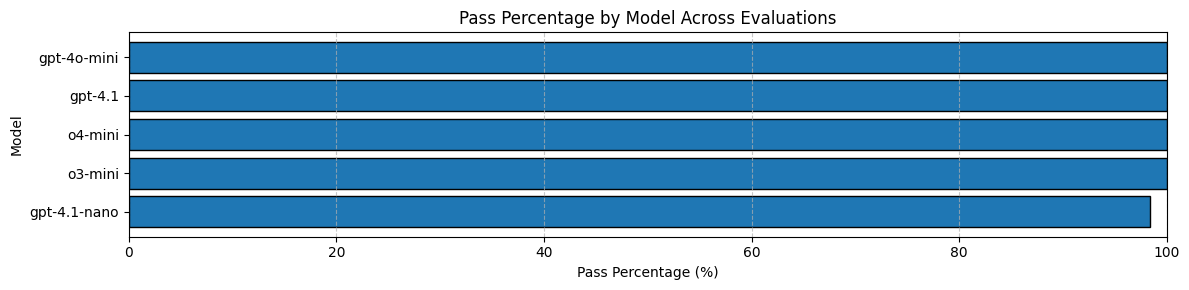

Fetching scores...
Failed to fetch output items for run evalrun_68de3a1c12ec8191901e1673f2e8faad. Error: 'Result' object has no attribute 'get'
Failed to fetch output items for run evalrun_68de3a1b62a08191baf55fccd2d56a43. Error: 'Result' object has no attribute 'get'
Failed to fetch output items for run evalrun_68de3a1aaaa48191873833fdad0ce272. Error: 'Result' object has no attribute 'get'
Failed to fetch output items for run evalrun_68de3a19df30819183e62fb4ecb97f8f. Error: 'Result' object has no attribute 'get'
Failed to fetch output items for run evalrun_68de3a18e02c81918b7013265fc82363. Error: 'Result' object has no attribute 'get'


In [20]:
# Let's visualize our evaluation and identify the best and worst performers.
display_evaluation_summary(client, [baseline_eval.id], x_range=(1, 10))

In [21]:
import pickle
import json

# Save the evaluation objects and runs
export_data = {
    'baseline_eval_id': baseline_eval.id,
    'baseline_runs_ids': [run.id for run in baseline_runs],
    'baseline_runs_models': [run.model for run in baseline_runs],
    'qa_validation': qa_validation,
    'GRADER_MODEL': GRADER_MODEL,
    'GRADER_PROMPT': GRADER_PROMPT,
    'SYSTEM_PROMPT': SYSTEM_PROMPT,
    'UNIQUE_ENOUGH_KEY': UNIQUE_ENOUGH_KEY
}

# Save to a JSON file
with open('../data/distillation_export.json', 'w') as f:
    json.dump(export_data, f, indent=2)

print("✅ Exported data for distillation notebook")

✅ Exported data for distillation notebook


---

## 7. Teardown

Don't forget to clean up - delete the resource group, purge resources!

---

## 8. Summary 

In this notebook we demonstrated **distillation** using Azure OpenAI *Evaluations*
and *Fine Tuning* features.

We used an objective of *adjusting the tone* of a model to meet our needs, in this
case making its responses sarcastic, while preserving accuracy in results, and
*distilled* the native capabilities of a state-of-the-art reasoning model (`o3`)
into a much smaller, non-reasoning model (`4.1-nano`) to let our agent or app
use the smallest model possible while:

- 🤑 minimizing per-token costs
- 🏎️ improve performance (latency)

We did all this:

- without creating training data directly
- without knowing the ideal student model
- only by knowing how to define our Grader

So to wrap it all up:

1. We described the ideal state to our complex reasoning model in the form of
   a few samples we feel are ideal.
2. We described to the reasoning model (grader) how to judge those examples
   to measure their quality.
3. We let Evaluations and Fine Tuning do the rest!